## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

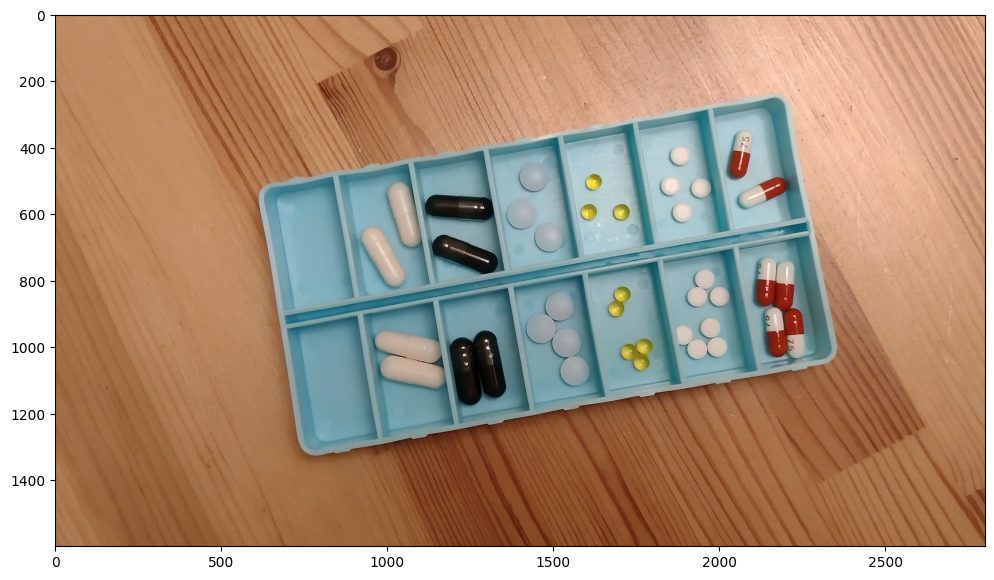

In [6]:
calib = cv2.imread('Lab5_dane/calib.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib[..., ::-1]);

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [7]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

In [8]:
class Pill:
    """Output of object detection, represents a single instance"""
    def __init__(self, pill_type: PillType, location: Any):
        self.type = pill_type
        self.location = location

In [17]:
import numpy as np

def detect_objects(image: np.ndarray, **kwargs) -> list[Pill]:
    def mult_and(binarized):
        if not binarized:
            return None
        img = binarized[0].copy()
        for img2 in binarized[1:]:
            img = cv2.bitwise_and(img, img2)
        return img
    
    def remove_other_pills(bin, other):
        img = bin.copy()
        for img2 in other:
            img = cv2.bitwise_and(img, cv2.erode(img2, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE))
        return img

    def apply_threshold(channel, thresh_range, inside=True):
        _, lower_binary = cv2.threshold(channel, thresh_range[0], 255, cv2.THRESH_BINARY)
        _, upper_binary = cv2.threshold(channel, thresh_range[1], 255, cv2.THRESH_BINARY_INV)
        binary = cv2.bitwise_and(lower_binary, upper_binary)
        return binary if inside else ~binary

    def apply_full_threshold(img_rgb, img_hsv, r_range, g_range, b_range, h_range, s_range, v_range,
                            r_inside=True, g_inside=True, b_inside=True, h_inside=True, s_inside=True, v_inside=True):
        r, g, b = cv2.split(img_rgb)
        h, s, v = cv2.split(img_hsv)

        bin_r = apply_threshold(r, r_range, r_inside)
        bin_g = apply_threshold(g, g_range, g_inside)
        bin_b = apply_threshold(b, b_range, b_inside)
        bin_h = apply_threshold(h, h_range, h_inside)
        bin_s = apply_threshold(s, s_range, s_inside)
        bin_v = apply_threshold(v, v_range, v_inside)

        return mult_and([bin_r, bin_g, bin_b, bin_h, bin_s, bin_v])
    
    def detect_circles(img, pill_type: PillType, hough_args):
        circles = cv2.HoughCircles(
            cv2.GaussianBlur(img, (9, 9), 3),
            cv2.HOUGH_GRADIENT, 
            dp=1,
            minRadius=0, 
            maxRadius=0,
            **hough_args
        )
        pills = []
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for circle in circles[0, :]:
                pills.append(Pill(pill_type, {'type': 'round', 'circle': circle}))
        return pills
    
    def detect_elipses(img, pill_type: PillType):
        contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        pills = []
        for contour in contours:
            if len(contour) >= 5:
                ellipse = cv2.fitEllipse(contour)
                pills.append(Pill(pill_type, {'type': 'long', 'ellipse': ellipse}))
        return pills

    def separate(bin_full, bin_part):
        num_labels, markers = cv2.connectedComponents(bin_part)
        separated = bin_full.copy()
        cv2.watershed(cv2.merge([separated] * 3), markers)
        separated[markers == -1] = 0
        separated = cv2.erode(separated, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
        return separated

    all_pills = []

    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    kernel = np.ones((3, 3), dtype=np.uint8)

    kernel_2 = np.zeros((3, 3), dtype=np.uint8)
    kernel_2[1, :] = 1
    kernel_2[:, 1] = 1

    kernel_3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))

    # detect background
    _, binary = cv2.threshold(image_hsv[:,:,0], 40, 255, cv2.THRESH_BINARY)
    box = cv2.morphologyEx(binary, op=cv2.MORPH_CLOSE, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=20)

    # detect espu
    _, lower_binary = cv2.threshold(image_hsv[:,:,0], 22, 255, cv2.THRESH_BINARY)
    _, upper_binary = cv2.threshold(image_hsv[:,:,0], 32, 255, cv2.THRESH_BINARY_INV)
    espu = cv2.bitwise_and(lower_binary, upper_binary)
    espu = cv2.morphologyEx(espu, op=cv2.MORPH_OPEN, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=2)
    all_pills.extend(detect_circles(espu, PillType.ESPU, {'minDist': 20, 'param1': 50, 'param2': 25}))

    # detect keto
    _, lower_binary = cv2.threshold(image_hsv[:,:,1], 30, 255, cv2.THRESH_BINARY)
    keto = cv2.morphologyEx(~lower_binary, op=cv2.MORPH_OPEN, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=6)
    all_pills.extend(detect_circles(keto, PillType.KETO, {'minDist': 20, 'param1': 50, 'param2': 25}))

    # detect carbon
    _, lower_binary = cv2.threshold(image_hsv[:,:,2], 60, 255, cv2.THRESH_BINARY)
    carbon = cv2.morphologyEx(~lower_binary, op=cv2.MORPH_OPEN, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=1)
    carbon = cv2.morphologyEx(carbon, op=cv2.MORPH_CLOSE, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=3)
    _, lower_binary = cv2.threshold(image[:,:,1], 25, 255, cv2.THRESH_BINARY)
    carbon_part = cv2.morphologyEx(lower_binary, op=cv2.MORPH_CLOSE, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=1)
    carbon_part = cv2.bitwise_and(carbon, carbon_part)
    carbon_part = cv2.morphologyEx(carbon_part, op=cv2.MORPH_OPEN, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=2)
    carbon_separated = separate(carbon, carbon_part)
    all_pills.extend(detect_elipses(carbon_separated, PillType.CARBON))

    # detect biox
    biox = apply_full_threshold(image, image_hsv, (172, 255), (168, 240), (159, 227), (8, 40), (8, 39), (172, 255))
    biox = cv2.morphologyEx(biox, op=cv2.MORPH_OPEN, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=4)
    biox = cv2.dilate(biox, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    all_pills.extend(detect_circles(biox, PillType.BIOX, {'minDist': 20, 'param1': 50, 'param2': 25}))

    # detect probio
    probio_center = apply_full_threshold(image, image_hsv, (105, 216), (119, 193), (113, 178), (11, 88), (15, 62), (121, 216))
    probio_center = cv2.morphologyEx(probio_center, op=cv2.MORPH_OPEN, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=2)
    probio_center = cv2.morphologyEx(probio_center, op=cv2.MORPH_CLOSE, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=4)
    probio_center = cv2.morphologyEx(probio_center, op=cv2.MORPH_OPEN, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=5)
    _, lower_binary = cv2.threshold(image_hsv[:,:,1], 25, 255, cv2.THRESH_BINARY)
    _, upper_binary = cv2.threshold(image_hsv[:,:,1], 70, 255, cv2.THRESH_BINARY_INV)
    bin = cv2.bitwise_and(lower_binary, upper_binary)
    probio_center = cv2.bitwise_and(probio_center, bin)
    probio_center = cv2.erode(probio_center, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    _, lower_binary = cv2.threshold(image_hsv[:,:,0], 40, 255, cv2.THRESH_BINARY)
    bin2 = cv2.morphologyEx(~lower_binary, op=cv2.MORPH_OPEN, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=1)
    bin2 = cv2.dilate(bin2, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    num_labels, labels = cv2.connectedComponents(bin2)
    probio = np.zeros_like(bin2)
    for label in range(0, num_labels):
        object_mask = (labels == label).astype(np.uint8) * 255
        intersection = cv2.bitwise_and(object_mask, probio_center)
        if np.any(intersection):
            probio = cv2.bitwise_or(probio, object_mask)
    probio_separated = separate(probio, probio_center)
    all_pills.extend(detect_elipses(probio_separated, PillType.PROBIO))

    # detect line
    line = remove_other_pills(bin2, [box, ~carbon, ~biox, ~espu, ~probio])
    line = cv2.morphologyEx(line, op=cv2.MORPH_OPEN, kernel=kernel_3, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=1)
    all_pills.extend(detect_elipses(line, PillType.LINE))

    return all_pills

In [30]:
COLORMAP = {
    # RGB colorspace
    PillType.PROBIO: (255, 255, 255),
    PillType.CARBON: (0, 0, 0),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}

def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    # TU BĘDZIE TWOJA IMPLEMENTACJA METODY WIZUALIZACJI
    image = image.copy()

    colors = {
        PillType.PROBIO: (255, 0, 0),    # duże białe kapsułki
        PillType.CARBON: (255, 255, 0),    # duże czarne kapsułki
        PillType.KETO: (255, 0, 255),      # niebieskie tabletki
        PillType.ESPU: (0, 255, 0),      # małe żółte kapsułki
        PillType.BIOX: (0, 0, 255),      # małe białe tabletki
        PillType.LINE: (0, 255, 255)      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)
    }
    
    for pill in objects:
        if pill.location['type'] == 'round':
            cv2.circle(image, (pill.location['circle'][0], pill.location['circle'][1]), pill.location['circle'][2], colors[pill.type], 5)
            cv2.circle(image, (pill.location['circle'][0], pill.location['circle'][1]), 10, (0, 0, 0), -1)
        elif pill.location['type'] == 'long':
            cv2.ellipse(image, pill.location['ellipse'], colors[pill.type], 5)
            cv2.circle(image, [int(pill.location['ellipse'][0][0]), int(pill.location['ellipse'][0][1])], 10, (255, 255, 255), 5)

    plt.imshow(image)

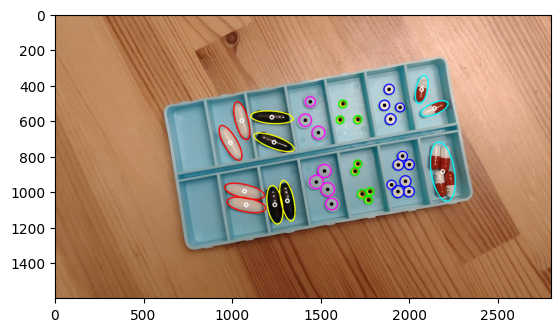

In [31]:
calib_rgb = cv2.cvtColor(calib, cv2.COLOR_BGR2RGB)
found = detect_objects(calib_rgb)
display_objects(calib_rgb, found)

### Test

Przetestuj swój algorytm na obrazie testowym `test.png` (lub `test_line.png`, jeśli podejmujesz się detekcji klasy LINE).
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

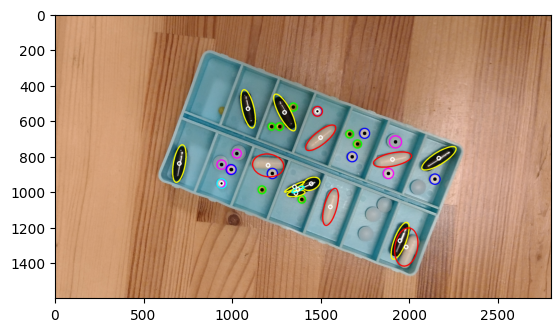

In [32]:
test_rgb = cv2.cvtColor(cv2.imread('Lab5_dane/test.png'), cv2.COLOR_BGR2RGB)
found = detect_objects(test_rgb)
display_objects(test_rgb, found)

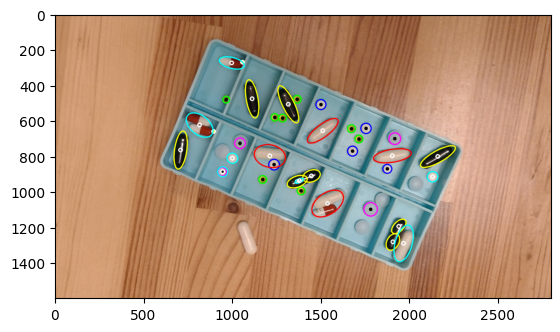

In [33]:
test2_rgb = cv2.cvtColor(cv2.imread('Lab5_dane/test_line.png'), cv2.COLOR_BGR2RGB)
found = detect_objects(test2_rgb)
display_objects(test2_rgb, found)

---

### Zadanie dodatkowe - dla chętnych

Cel: zliczenie wystąpień leków w poszczególnych komórkach organizera.

Wykorzystaj transformację Hougha do wykrycia linii oddzielających komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
żadne szczegóły implementacyjne tej struktury nie są narzucone.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.